In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score

[*********************100%***********************]  1 of 1 completed


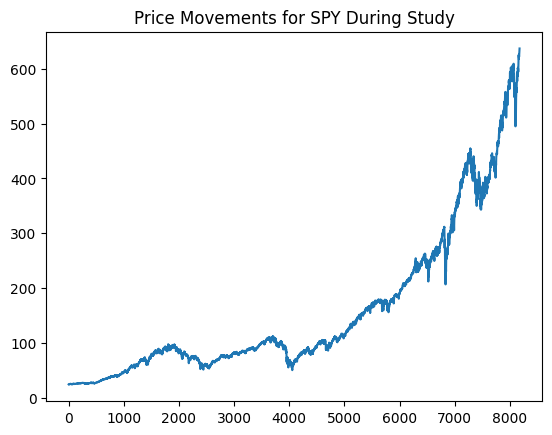

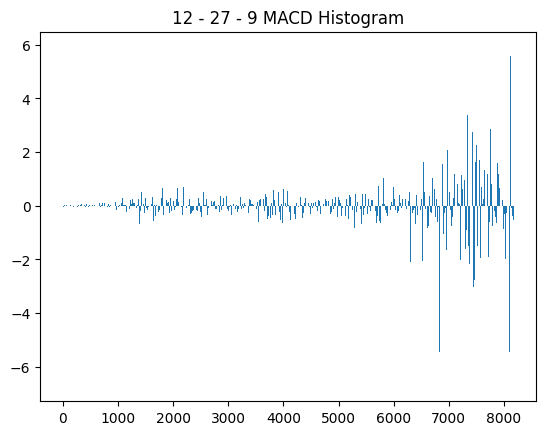

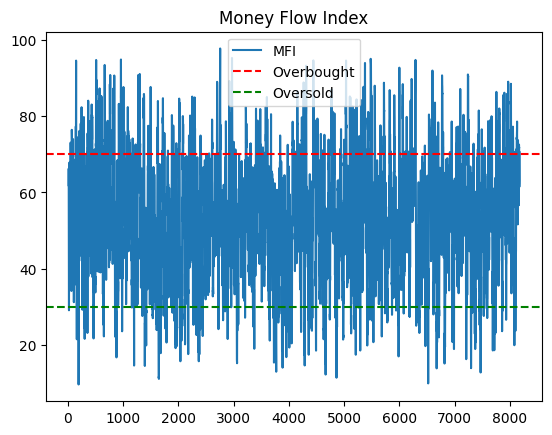

5691


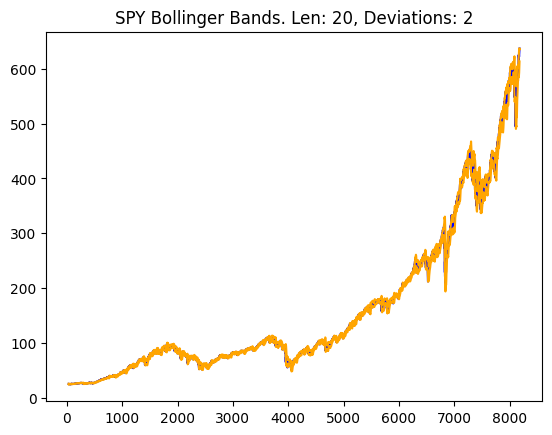

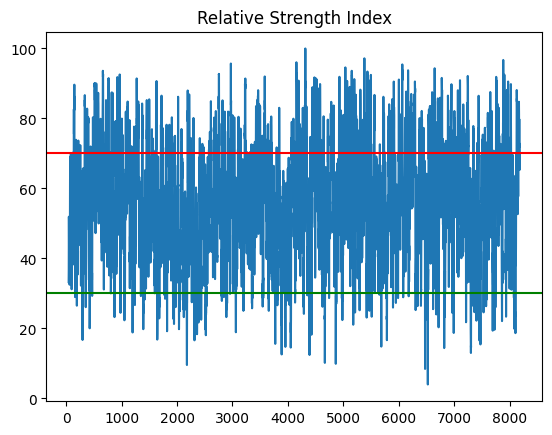

In [ ]:
TICKER = 'SPY'
INTERVAL = '1d'
PERIOD = '730d' if INTERVAL == '1h' else 'max'
SHIFT = 1
SHIFT_RANGE = range(1, 120)
MACD_FAST = 12
MACD_SLOW = 27
MACD_SPAN = 9
MFI_LENGTH = 14
MFI_OVERBOUGHT = 70
MFI_OVERSOLD = 30
RSI_LENGTH = 14
RSI_OVERBOUGHT = 70
RSI_OVERSOLD = 30
BB_LEN = 20
DEVS = 2
CUTOFF = .5
TRAIN_SIZE = .7

LOOKBACK = 10000

STRATEGY = ['Volume_change', 'Close_change', 'High_change', 'Low_change', 'Open_change', 'BB', 'MACD_hist', 'RSI', 'MFI']
OPTIMAL_SHIFT = None

def get_data(ticker=TICKER, lookback=LOOKBACK, interval=INTERVAL):
    df = yf.download(ticker, interval=interval, auto_adjust=True, period=PERIOD)
    df.columns = df.columns.get_level_values(0)
    df = df.reset_index(drop=True)

    for c in df.columns:
        df[f'{c}_change'] = df[c].pct_change() * 100

    # only return the subset of data you are interested in
    subset = df.iloc[-lookback:, :]
    plt.figure()
    plt.plot(subset['Close'])
    plt.title(f'Price Movements for {ticker} During Study')

    return subset.dropna()

def add_BB(df, devs=DEVS, bb_len=BB_LEN):

    # can change to ema (use MACD video/code for reference)
    df['BB_SMA'] = df['Close'].rolling(bb_len).mean()

    # get the standard deviation of the close prices for the period
    df['BB_STD'] = df['Close'].rolling(bb_len).std()

    df['Upper_Band'] = df['BB_SMA'] + (devs * df['BB_STD'])
    df['Lower_Band'] = df['BB_SMA'] - (devs * df['BB_STD'])

    df['BB'] = (df['Upper_Band'] - df['Close']) / (df['Upper_Band'] - df['Lower_Band'])

    df = df.dropna()

    plt.figure()
    plt.plot(df['Close'], color='blue')
    plt.plot(df['Upper_Band'], color='orange')
    plt.plot(df['Lower_Band'], color='orange')
    plt.title(f'{TICKER} Bollinger Bands. Len: {BB_LEN}, Deviations: {DEVS}');

    return df

def add_RSI(df, length=RSI_LENGTH, overbought=RSI_OVERBOUGHT, oversold=RSI_OVERSOLD):

    price_change = df['Close'].diff()
    
    # separate gains/losses
    gain = price_change.where(price_change > 0, 0)
    loss = -price_change.where(price_change < 0, 0)

    # average gain vs loss
    avg_gain = gain.rolling(window=length).mean()
    avg_loss = loss.rolling(window=length).mean()

    # calculate rsi
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    df['RSI'] = rsi

    # plot the relative strength index
    plt.figure()
    plt.plot(df['RSI'])
    plt.axhline(overbought, color='red')
    plt.axhline(oversold, color='green')
    plt.title('Relative Strength Index')

    return df.dropna()

def add_MACD(df, fast=MACD_FAST, slow=MACD_SLOW, span=MACD_SPAN):

    df[f'{fast}_ema'] = df['Close'].ewm(span=fast).mean()
    df[f'{slow}_ema'] = df['Close'].ewm(span=slow).mean()

    # macd line is the difference betweent he fast and slow
    df[f'MACD'] = df[f'{fast}_ema'] - df[f'{slow}_ema']

    # macd signal is a 9-period moving average of this line
    df['Signal'] = df['MACD'].ewm(span=span).mean()

    # MACD histogram is almost always what is used in TA
    df['MACD_hist'] = df['MACD'] - df['Signal']

    # plot the histogram
    plt.figure()
    plt.bar(x=range(len(df)), height=df['MACD_hist'])
    plt.title(f'{MACD_FAST} - {MACD_SLOW} - {MACD_SPAN} MACD Histogram')

    return df

def add_MFI(df, length=MFI_LENGTH, overbought=MFI_OVERBOUGHT, oversold=MFI_OVERSOLD):
    df = df.copy()

    # Step 1: Calculate typical price
    df['Typical_Price'] = (df['High'] + df['Low'] + df['Close']) / 3

    # Step 2: Calculate raw money flow
    df['Raw_Money_Flow'] = df['Typical_Price'] * df['Volume']

    # Step 3: Classify positive/negative money flow
    df['Price_Change'] = df['Typical_Price'].diff()

    df['Pos_Flow'] = np.where(df['Price_Change'] > 0, df['Raw_Money_Flow'], 0)
    df['Neg_Flow'] = np.where(df['Price_Change'] < 0, df['Raw_Money_Flow'], 0)

    # Step 4: Money Flow Ratio and MFI
    pos_sum = df['Pos_Flow'].rolling(window=length).sum()
    neg_sum = df['Neg_Flow'].rolling(window=length).sum()
    mfr = pos_sum / neg_sum
    df['MFI'] = 100 - (100 / (1 + mfr))

    # Step 5: Plot
    plt.figure()
    plt.plot(df['MFI'], label='MFI')
    plt.axhline(overbought, color='red', linestyle='--', label='Overbought')
    plt.axhline(oversold, color='green', linestyle='--', label='Oversold')
    plt.title('Money Flow Index')
    plt.legend()
    plt.show()

    return df.dropna()

def add_target(df, shift=SHIFT):
    df = df.copy()
    df[f'Close + {shift}'] = df['Close'].shift(-shift)
    df['Target'] = (df[f'Close + {shift}'] > df['Close']).astype(int)
    return df.dropna().reset_index(drop=True)

def train_test_split(df, train_size=TRAIN_SIZE):
    
    split = int((len(df) * train_size))

    train = df.iloc[:split, :]
    test = df.iloc[split:, :]

    print(split)
    return df, train, test

def main():
    
    # Load and preprocess data once
    df = get_data()
    df = add_MACD(df)
    df = add_MFI(df)
    df = add_BB(df)
    df = add_RSI(df)
    df = add_target(df)
    df, train, test = train_test_split(df)

    return df, train, test

df, train, test = main()

In [3]:
train

Price,Close,High,Low,Open,Volume,Close_change,High_change,Low_change,Open_change,Volume_change,...,Neg_Flow,MFI,BB_SMA,BB_STD,Upper_Band,Lower_Band,BB,RSI,Close + 1,Target
0,56.130630,56.476050,55.516552,55.881161,5484300,0.601883,-0.641467,-0.327313,-1.086965,27.839161,...,3.073461e+08,35.655171,57.270037,1.051939,59.373914,55.166159,0.770787,37.792914,55.276661,0
1,398.049133,398.350550,394.507561,396.306603,55938800,0.914595,0.697649,0.614978,0.694035,-3.784048,...,0.000000e+00,49.739479,392.409956,4.111195,400.632346,384.187567,0.157084,62.615406,397.662964,0
2,487.556274,489.175698,485.289075,488.498480,71736700,-0.550537,-0.886905,-0.862150,-0.793302,-5.025889,...,3.496019e+10,57.476788,484.373346,5.772239,495.917825,472.828867,0.362145,55.843085,487.997925,1
3,74.391464,74.592468,74.313654,74.456304,5728800,-0.191405,-0.026093,0.358999,-0.173888,-59.189896,...,0.000000e+00,55.312124,74.176529,0.871275,75.919078,72.433979,0.438327,49.387185,74.799973,1
4,111.039421,111.765271,110.163666,110.289891,138832200,0.621977,1.034124,0.100329,-0.228433,20.626941,...,0.000000e+00,55.344824,109.383402,1.189053,111.761507,107.005296,0.151820,64.060220,110.708084,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5686,56.840649,56.946193,55.612491,55.881151,8087800,-0.033793,-1.608133,-1.662751,-3.320095,49.979602,...,4.566893e+08,38.858312,57.551648,0.969775,59.491199,55.612098,0.683290,41.428485,56.629574,0
5687,55.625900,55.915723,55.098956,55.573209,53638000,-0.471345,-1.906559,-0.982407,-1.609250,-2.953831,...,2.979422e+09,43.996174,58.251736,2.189022,62.629779,53.873692,0.799887,24.443394,54.947422,0
5688,81.370369,81.804871,80.244614,80.540865,7498900,1.527842,0.242010,0.172580,-0.778593,-1.073836,...,0.000000e+00,21.393209,83.279558,1.841781,86.963120,79.595997,0.759150,29.776378,81.192604,0
5689,149.381821,150.364809,149.152457,150.307474,108028200,-0.289794,-0.021795,-0.301160,0.141900,32.728104,...,1.616459e+10,68.736812,148.300755,2.016576,152.333907,144.267602,0.365978,72.653035,150.299316,1


In [4]:
test

Price,Close,High,Low,Open,Volume,Close_change,High_change,Low_change,Open_change,Volume_change,...,Neg_Flow,MFI,BB_SMA,BB_STD,Upper_Band,Lower_Band,BB,RSI,Close + 1,Target
5691,82.340767,82.340767,81.605250,81.642773,173873600,0.365918,0.265020,1.219502,0.055171,-9.167200,...,0.000000e+00,63.467347,79.654257,1.361730,82.377718,76.930796,0.006784,69.685545,81.725342,0
5692,601.715698,602.262420,598.852795,598.972077,30056700,0.076053,0.059450,-0.051434,-0.245030,15.386564,...,0.000000e+00,63.223780,597.678830,6.427087,610.533004,584.824656,0.342974,48.885382,599.777283,0
5693,70.518715,70.605334,69.892418,70.285519,33558800,0.075595,-0.282338,-0.644104,-0.471785,6.801691,...,2.360486e+09,52.868448,69.832155,0.531531,70.895216,68.769094,0.177083,53.174943,70.891876,1
5694,242.946396,244.407955,242.616661,244.149503,52966400,-0.277995,0.098564,-0.121056,0.347986,-8.719382,...,1.288798e+10,58.154834,239.358479,3.349042,246.056563,232.660396,0.232168,76.627342,243.614639,1
5695,86.814735,87.990935,86.814735,87.829906,102405700,-1.626362,-1.350100,-1.368142,-1.337028,24.035959,...,8.930474e+09,56.623349,87.980975,0.995126,89.971227,85.990723,0.792988,48.030646,86.478699,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8126,171.960617,172.177768,170.365460,170.382154,147217800,1.774551,1.696971,1.548236,1.285916,17.448485,...,0.000000e+00,51.059225,170.434615,3.053046,176.540708,164.328522,0.375043,61.334004,170.582535,0
8127,188.062866,188.329852,187.236059,187.270516,70502200,0.492413,-0.205385,0.531769,-0.220282,-42.450143,...,0.000000e+00,38.145111,187.702022,0.812986,189.327995,186.076049,0.389037,51.136389,187.752899,0
8128,103.972893,105.692159,103.793802,104.366894,277745100,-1.372669,-0.579526,-0.124094,-1.554172,-25.837715,...,2.902055e+10,32.683397,108.602035,1.893908,112.389851,104.814219,1.111057,36.956447,102.941338,0
8129,42.200500,42.674238,42.153127,42.598440,528800,-0.779691,-0.442094,-0.714134,-0.288320,36.923874,...,2.239078e+07,62.165760,41.765782,0.487572,42.740925,40.790638,0.277100,68.527421,42.115215,0
